kernel Linear


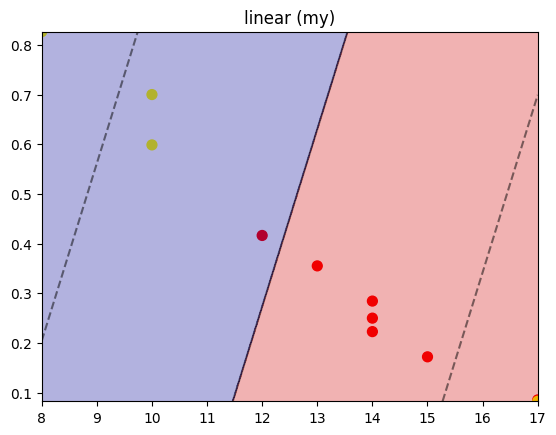

Results:
[0.41630962 0.69997495 0.28422711 0.0852643  0.5986333  0.08250241
 0.17199238 0.22272733 0.24987414 0.8265711  0.35506859]
Results inLib:
[0 1 0 0 1 0 0 0 0 1 0]
Количество ошибок для отложенной выборки:  1


In [39]:
import numpy as np
from PIL import Image
import random as rnd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap
def test_plot(X, y, svm_model, axes, title):
  plt.axes(axes)
  xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
  ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0
  
  svm_model.fit(X, y)
  z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
  plt.title(title)
  plt.show()
def nonlin(x,deriv=False):
    if(deriv==True):
        return np.exp(-x)/((1 + np.exp(-x))*(1 + np.exp(-x)))
    return 1/(1+np.exp(-x))

def sigmoid(x):
  # функция активации: f(x) = 1 / (1 + e^(-x))
  return 1 / (1 + np.exp(-x))

def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended

def newline(p1, p2, color=None): # функция отрисовки линии
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l


f = open("C:\\Users\\ferru\\OneDrive\\Рабочий стол\\5semester\\Нейронки\\3lab\\config.txt", mode="r", encoding="utf-8")
y_train = []
y_test = []
train = []
test = []
flag = True
for line in f:
    if(line == ""):
        break
    if(line == "==\n"):
        flag = False
        continue
    if(flag):
        if(line.find("car") == -1):
            y_train.append(1)
        else:
            y_train.append(0)
        tr = Image.open(line[:-1], 'r').convert('L')

        arr = np.array(tr)
        train.append(arr.ravel())
    else:
        if(line.find("car") == -1):
            y_test.append(1)
        else:
            y_test.append(0)
        tr = Image.open(line[:-1], 'r').convert('L')
        arr = np.array(tr)
        test.append(arr.ravel())

for line in train:
    for i in range(len(line)):
        if(line[i] == 0):
            line[i] = 1
        else:
            line[i] = 0
for line in test:
    for i in range(len(line)):
        if(line[i] == 0):
            line[i] = 1
        else:
            line[i] = 0

train = np.array(train)
test = np.array(test)
y_train = np.array(y_train)
y_test = np.array(y_test)

for i in range(len(y_train)):
        if(y_train[i] == 0):
            y_train[i] = 1
        else:
            y_train[i] = 0
for i in range(len(y_test)):
        if(y_test[i] == 0):
            y_test[i] = 1
        else:
            y_test[i] = 0



class SVM:
  def __init__(self, kernel='linear', C=10, max_iter=100000, degree=3, gamma=1):
    self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
         'rbf': lambda x,y: np.exp(-gamma*np.sum((y-x[:,np.newaxis])**2,axis=-1)),
         'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter

  # ограничение параметра t, чтобы новые лямбды не покидали границ квадрата
  def restrict_to_square(self, t, v0, u): 
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X.copy()
    # преобразование классов 0,1 в -1,+1; для лучшей совместимости с sklearn
    self.y = y * 2 - 1 
    self.lambdas = np.zeros_like(self.y, dtype=float)
    # формула (3)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    # выполняем self.max_iter итераций
    for _ in range(self.max_iter):
      # проходим по всем лямбда 
      for idxM in range(len(self.lambdas)):                                    
        # idxL выбираем случайно
        idxL = np.random.randint(0, len(self.lambdas))                         
        # формула (4с)
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]] 
        # формула (4a)
        v0 = self.lambdas[[idxM, idxL]]                                        
        # формула (4b)
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)           
        # формула (4d)
        u = np.array([-self.y[idxL], self.y[idxM]])                            
        # регуляризированная формула (5), регуляризация только для idxM = idxL
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15) 
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    # найти индексы опорных векторов
    idx, = np.nonzero(self.lambdas > 1E-15) 
    # формула (1)
    self.b = np.mean((1.0-np.sum(self.K[idx]*self.lambdas, axis=1))*self.y[idx]) 
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

  def predict(self, X): 
    # преобразование классов -1,+1 в 0,1; для лучшей совместимости с sklearn
   # return (np.sign(self.decision_function(X)) + 1) // 2
   return nonlin(self.decision_function(X)) 

svm =  SVM(kernel='linear', max_iter=100)
svm.fit(train, y_train)

from sklearn.svm import SVC


print("kernel Linear")
y_pred = svm.predict(test)
X = []
for i in range(len(y_pred)):
    X.append([sum(test[i]), y_pred[i]])
X = np.array(X)
fig, axs = plt.subplots(nrows=1)
test_plot(X, y_test, SVM(kernel='linear', C=10, max_iter=60), axs, 'linear (my)')
print("Results:")
print(y_pred)
graftest = []
for i in test:
    graftest.append(sum(i))

print("Results inLib:")
svm = SVC(kernel='linear', C=10)
svm.fit(train, y_train)
print(svm.predict(test))
y_pred = svm.predict(test)
y_pred[y_pred != y_test] = -100 # find and mark classification error
linearSVC = (y_pred == -100).astype(int).sum()
print('Количество ошибок для отложенной выборки: ', linearSVC)
